# Classify MHW events using SST and in situ data: shallow, extended, or sub-surface events


The goal of the code is to define and analyze surface, extended and sub-surface marine heatwaves (MHWs) using temperature data from different depths. The code also creates figures 2,3,5 and S1 from the related article.

In [1]:
import datetime
import glob
import shelve

import cmocean
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from statsmodels.stats.proportion import proportions_ztest
from datetime import date, timedelta
import operator
from scipy import stats


In [2]:
Name_platform = 'ORS065'
ClimatologyPeriod=[1992,2020] 
MHWPeriod = [1992,2020] 
mhwname = 'MHWS_2020'
plot_folder  = 'FIGURES/' 


# For figures
from matplotlib.colors import LinearSegmentedColormap
col_cat0 = (.95, .95, .95) # no
col_cat1 =  (255/255, 218/255, 103/255) # Moderate
col_cat2 =  (242/255, 103/255, 33/255) # Strong
colors = [col_cat0, col_cat1, col_cat2]

customPalette_cat = sns.set_palette(sns.color_palette(colors))


# Import MHW data from ORS065

In [3]:
# Dataset
list_FILES = sorted(glob.glob('DATA_processed/SAVE_' + Name_platform + '_mhws_Strength2018' + '_z*.dir')) #print(list_FILES[0][0:-4])
N_FILES = len(list_FILES)
print("Check number of files: " + str(N_FILES))
Depth_all = np.zeros(N_FILES)+np.nan


# Loop through all files and depths
for f in range(N_FILES):
    FILE = list_FILES[f][0:-4]     
    print(FILE)

    d = shelve.open(FILE)  # Note: getting rid of .dir!
    depth = d['DEPTHS'] 
    Depth_all[f] = depth
    mhws_ORS065 = d['dict_mhws']  
    clim_ORS065 = d['dict_clim']
    t_ORS065 = clim_ORS065['t']
    year_stats_ORS065 = d['dict_year_stats']
    d.close()    
    
    if depth==15:
        mhws_ORS065_15m = mhws_ORS065
    if depth==20:
        mhws_ORS065_20m = mhws_ORS065
    if depth==30:
        mhws_ORS065_30m = mhws_ORS065
    if depth==53:
        mhws_ORS065_53m = mhws_ORS065
    if f==0:
        sst_ano_2D = np.empty((N_FILES,len(t_ORS065))) + np.NaN
        sst_ano_thresh_2D = np.empty((N_FILES,len(t_ORS065))) + np.NaN
        sst_2D = np.empty((N_FILES,len(t_ORS065))) + np.NaN
        cat_2D = np.empty((N_FILES,len(t_ORS065))) + np.NaN

    # Get category of MHWs: moderate, strong
    cat = np.zeros(len(t_ORS065))

    for i in range(mhws_ORS065['n_events']):    
        t1 = np.where(t_ORS065==mhws_ORS065['time_start'][i])[0][0]
        t2 = np.where(t_ORS065==mhws_ORS065['time_end'][i])[0][0]
        if mhws_ORS065['category'][i] == 'Moderate':
            cat[t1:t2+1]=1
        if mhws_ORS065['category'][i] == 'Strong':
            cat[t1:t2+1]=2    
        cat[np.isnan(clim_ORS065['sst'])] = np.nan

        
    # Group everything into a gridded array
    sst_ano_2D[f,:] = clim_ORS065['sst_ano']
    sst_ano_thresh_2D[f,:] = clim_ORS065['sst_ano_thresh']
    sst_2D[f,:] = clim_ORS065['sst']
    cat_2D[f,:] = cat
  


Check number of files: 12
DATA_processed\SAVE_ORS065_mhws_Strength2018_z01
DATA_processed\SAVE_ORS065_mhws_Strength2018_z05
DATA_processed\SAVE_ORS065_mhws_Strength2018_z10
DATA_processed\SAVE_ORS065_mhws_Strength2018_z15
DATA_processed\SAVE_ORS065_mhws_Strength2018_z20
DATA_processed\SAVE_ORS065_mhws_Strength2018_z25
DATA_processed\SAVE_ORS065_mhws_Strength2018_z30
DATA_processed\SAVE_ORS065_mhws_Strength2018_z35
DATA_processed\SAVE_ORS065_mhws_Strength2018_z40
DATA_processed\SAVE_ORS065_mhws_Strength2018_z45
DATA_processed\SAVE_ORS065_mhws_Strength2018_z50
DATA_processed\SAVE_ORS065_mhws_Strength2018_z53


# Import MHW data from SST

In [4]:
## Get the data from file
Name_platform_SST = 'SST_ESA'
d = shelve.open('SSAVE_' + Name_platform_SST + '_mhws_Strength2018_sst2019') 
mhws_SST = d['dict_mhws']  
clim_SST = d['dict_clim']
d.close()    
t_SST = clim_SST['t']

print(clim_SST['times_dates'])

# Convert to numbers
x = mdates.date2num(clim_SST['times_dates'])

# Get category of MHWs: moderate, strong
cat_SST = np.zeros(len(t_SST))
cat_SST[np.isnan(clim_SST['sst'])] = np.nan

for i in range(mhws_SST['n_events']):    
    t1 = np.where(t_SST==mhws_SST['time_start'][i])[0][0]
    t2 = np.where(t_SST==mhws_SST['time_end'][i])[0][0]
    if mhws_SST['category'][i] == 'Moderate':
        cat_SST[t1:t2+1]=1
    if mhws_SST['category'][i] == 'Strong':
        cat_SST[t1:t2+1]=2


[datetime.datetime(1992, 1, 1, 0, 0) datetime.datetime(1992, 1, 2, 0, 0)
 datetime.datetime(1992, 1, 3, 0, 0) ...
 datetime.datetime(2019, 12, 29, 0, 0)
 datetime.datetime(2019, 12, 30, 0, 0)
 datetime.datetime(2019, 12, 31, 0, 0)]


## Merge SST and ORS065 dataset

In [5]:

# Add SST to temperature ORS2D
cat_2Dadd = np.append([cat_SST],cat_2D,axis=0)
cat_2Dadd_init = cat_2Dadd.copy()
cat_2Dadd[1:3,:] = np.nan # because the shallow time-series stopped in 2006

sst_2Dadd = np.append([clim_SST['sst']],sst_2D,axis=0)
sst_ano_2Dadd = np.append([clim_SST['sst_ano']],sst_ano_2D,axis=0)
sst_ano_thresh_2Dadd = np.append([clim_SST['sst_ano_thresh']],sst_ano_thresh_2D,axis=0)
Depth_alladd = np.append([0],Depth_all,axis=0)

t = mdates.date2num(clim_SST['times_dates'])



# Stratification and seasons

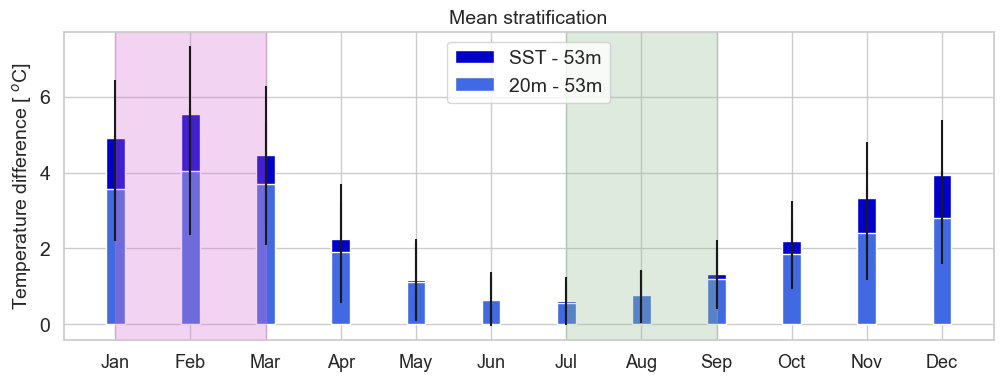

In [6]:
# ARCTICLE figure 3e
month_t = np.array([date.fromordinal(t_ORS065[i]).month for i in range(len(t_ORS065))])    # note starts datetime.date(1990, 11, 14)
temp_diff_SST_50m = sst_2Dadd[Depth_alladd==0,:][0] - sst_2Dadd[Depth_alladd==50,:][0] 
temp_diff_20m_50m = np.array(sst_2Dadd[Depth_alladd==20,:][0] - sst_2Dadd[Depth_alladd==50,:][0]) 

df_tempdiff_strat = pd.DataFrame({'Month': month_t,
                     'temp_diff_SST_50m': temp_diff_SST_50m,
                     'temp_diff_20m_50m': temp_diff_20m_50m},
                    pd.DatetimeIndex(clim_SST['times_dates']))


#  histogram per month / year
stratif_by_month = df_tempdiff_strat.groupby(df_tempdiff_strat.index.month).mean()
stratif_by_month_std = df_tempdiff_strat.groupby(df_tempdiff_strat.index.month).std()

# Figure
bar_width = 0.25
sns.set(style="whitegrid")  
sns.set_palette(sns.color_palette(colors))#
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

monthNames = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.figure(figsize=(12,4))
ax = plt.subplot(1,1,1)
plt.title(Name_platform, size=15)
plt.bar(stratif_by_month.index,stratif_by_month.temp_diff_SST_50m,bar_width,yerr=stratif_by_month_std.temp_diff_SST_50m,label='SST - 53m',color='mediumblue')
plt.bar(stratif_by_month.index,stratif_by_month.temp_diff_20m_50m,bar_width,yerr=stratif_by_month_std.temp_diff_20m_50m,label='20m - 53m',color='royalblue')
ax.set_xticks(np.arange(12)+1)
plt.legend(fontsize=14,loc=9)    
ax.set_xticklabels(monthNames,fontsize=13)
#ax.axhline(y=5,linewidth=1, color='grey')#,label="Cut-off 500 W m$^{-2}$")
ax.set_title('Mean stratification',fontsize=14)    
ax.set_ylabel('Temperature difference [ $^{o}$C]',fontsize=14)    
ax.fill_between(stratif_by_month.index, 0, 1, where=((stratif_by_month.index <4)), color='orchid', alpha=0.3, transform=ax.get_xaxis_transform())
ax.fill_between(stratif_by_month.index, 0, 1, where=((stratif_by_month.index > 6) & (stratif_by_month.index <10)), color='darkseagreen', alpha=0.3, transform=ax.get_xaxis_transform())
plt.savefig(plot_folder + 'plot_season_stratif_months.png', bbox_inches='tight', pad_inches=0.5, dpi=150)
plt.show()


# Define MHW coherence

In [7]:
# Common days SST / ORS065 at each depth, separately for seasons
common_days_winter = np.zeros(N_FILES+1)+np.nan
common_days_summer = np.zeros(N_FILES+1)+np.nan
common_days_winter_nans = np.zeros(N_FILES+1)+np.nan
common_days_summer_nans = np.zeros(N_FILES+1)+np.nan

month_list = np.array([date.fromordinal(t_ORS065[i]).month for i in range(len(t_ORS065))])    # note starts datetime.date(1990, 11, 14))

#NEW SEASONS based on  stratification
winter = ((np.array(month_list) >6) & (np.array(month_list) <10)) # July August September: weak stratification
summer = ((np.array(month_list) <4) ) # January February March: strong stratification

# Common days SST / ORS065
for i in range(np.size(Depth_alladd)):
    common_days_winter[i] = np.size(np.where((cat_2Dadd_init[Depth_alladd==0,:]>0) & (cat_2Dadd_init[Depth_alladd==Depth_alladd[i],:]>0) & winter)[1])
    common_days_summer[i] = np.size(np.where((cat_2Dadd_init[Depth_alladd==0,:]>0) & (cat_2Dadd_init[Depth_alladd==Depth_alladd[i],:]>0) & summer)[1])
    common_days_winter_nans[i] = np.size(np.where((cat_2Dadd_init[Depth_alladd==0,:]>0) & (np.isnan(cat_2Dadd_init[Depth_alladd==Depth_alladd[i],:])) & winter)[1])
    common_days_summer_nans[i] = np.size(np.where((cat_2Dadd_init[Depth_alladd==0,:]>0) & (np.isnan(cat_2Dadd_init[Depth_alladd==Depth_alladd[i],:])) & summer)[1])

# Calculate percentage of common days from SST, taking into account the missing values
common_days_winter_perc = common_days_winter / (common_days_winter[0]-common_days_winter_nans) *100
common_days_summer_perc = common_days_summer / (common_days_summer[0]-common_days_summer_nans) *100
common_days_winter_perc[1:4] = np.nan # shallow ORS data have a short coverage
common_days_summer_perc[1:4] = np.nan# shallow ORS data have a short coverage



In [8]:
# Add inforamtion on geostrophic meridional currents

# Load daily time-series of GEOSTROPHY from satellite, extracted off Sydney
d = shelve.open('DATA_raw_other/SSAVE_34_151_4daily_2020_v2')
df_GEO_all_daily = d['df_GEO_all_daily']
d.close()

common_days_GEO_pos = np.zeros(N_FILES + 1) + np.nan
common_days_GEO_neg = np.zeros(N_FILES + 1) + np.nan
common_days_GEO_pos_nans = np.zeros(N_FILES + 1) + np.nan
common_days_GEO_neg_nans = np.zeros(N_FILES + 1) + np.nan

# Common days SST / ORS065, now considering northward or southward large-scale geostrophic currents
GEO_VCUR_normalised = df_GEO_all_daily['GEO_VCUR_rot_ANO'].values / df_GEO_all_daily['GEO_VCUR_rot_STD'].values

for i in range(np.size(Depth_alladd)):
    common_days_GEO_pos[i] = np.sum((cat_2Dadd_init[Depth_alladd == 0, :] > 0) & (cat_2Dadd_init[Depth_alladd == Depth_alladd[i], :] > 0) & (GEO_VCUR_normalised > 0))
    common_days_GEO_neg[i] = np.sum((cat_2Dadd_init[Depth_alladd == 0, :] > 0) & (cat_2Dadd_init[Depth_alladd == Depth_alladd[i], :] > 0) & (GEO_VCUR_normalised < 0))
    common_days_GEO_pos_nans[i] = np.sum((cat_2Dadd_init[Depth_alladd == 0, :] > 0) & (np.isnan(cat_2Dadd_init[Depth_alladd == Depth_alladd[i], :])) & (GEO_VCUR_normalised > 0))
    common_days_GEO_neg_nans[i] = np.sum((cat_2Dadd_init[Depth_alladd == 0, :] > 0) & (np.isnan(cat_2Dadd_init[Depth_alladd == Depth_alladd[i], :])) & (GEO_VCUR_normalised < 0))

# Calculate percentage of common days from SST, taking into account the missing values
common_days_GEO_pos_perc = common_days_GEO_pos / (common_days_GEO_pos[0] - common_days_GEO_pos_nans) * 100
common_days_GEO_neg_perc = common_days_GEO_neg / (common_days_GEO_neg[0] - common_days_GEO_neg_nans) * 100
common_days_GEO_pos_perc[1:4] = np.nan
common_days_GEO_neg_perc[1:4] = np.nan



# Now do the same separetely by season

# Initialize arrays to store common days between variables
common_days_summer_GEO_pos = np.full(N_FILES + 1, np.nan)
common_days_summer_GEO_neg = np.full(N_FILES + 1, np.nan)
common_days_winter_GEO_pos = np.full(N_FILES + 1, np.nan)
common_days_winter_GEO_neg = np.full(N_FILES + 1, np.nan)
common_days_summer_GEO_pos_nans = np.full(N_FILES + 1, np.nan)
common_days_summer_GEO_neg_nans = np.full(N_FILES + 1, np.nan)
common_days_winter_GEO_pos_nans = np.full(N_FILES + 1, np.nan)
common_days_winter_GEO_neg_nans = np.full(N_FILES + 1, np.nan)

# Calculate geostrophic current normalized values
GEO_VCUR_normalised = df_GEO_all_daily['GEO_VCUR_rot_ANO'].values / df_GEO_all_daily['GEO_VCUR_rot_STD'].values

for i, depth in enumerate(Depth_alladd):
    mask = Depth_alladd == depth
    mask_depth_0 = cat_2Dadd_init[Depth_alladd == 0, :]
    mask_depth_i = cat_2Dadd_init[mask, :]
    
    # Calculate common days for different combinations of variables
    common_days_summer_GEO_pos[i] = np.sum((mask_depth_0 > 0) & (mask_depth_i > 0) & (GEO_VCUR_normalised > 0) & summer)
    common_days_winter_GEO_pos[i] = np.sum((mask_depth_0 > 0) & (mask_depth_i > 0) & (GEO_VCUR_normalised > 0) & winter)
    common_days_summer_GEO_neg[i] = np.sum((mask_depth_0 > 0) & (mask_depth_i > 0) & (GEO_VCUR_normalised < 0) & summer)
    common_days_winter_GEO_neg[i] = np.sum((mask_depth_0 > 0) & (mask_depth_i > 0) & (GEO_VCUR_normalised < 0) & winter)
    common_days_summer_GEO_pos_nans[i] = np.sum((mask_depth_0 > 0) & (np.isnan(mask_depth_i)) & (GEO_VCUR_normalised > 0) & summer)
    common_days_summer_GEO_neg_nans[i] = np.sum((mask_depth_0 > 0) & (np.isnan(mask_depth_i)) & (GEO_VCUR_normalised < 0) & summer)
    common_days_winter_GEO_pos_nans[i] = np.sum((mask_depth_0 > 0) & (np.isnan(mask_depth_i)) & (GEO_VCUR_normalised > 0) & winter)
    common_days_winter_GEO_neg_nans[i] = np.sum((mask_depth_0 > 0) & (np.isnan(mask_depth_i)) & (GEO_VCUR_normalised < 0) & winter)

# Calculate percentage of common days from SST
common_days_summer_GEO_pos_perc = common_days_summer_GEO_pos / (common_days_summer_GEO_pos[0] - common_days_summer_GEO_pos_nans) * 100
common_days_winter_GEO_pos_perc = common_days_winter_GEO_pos / (common_days_winter_GEO_pos[0] - common_days_winter_GEO_pos_nans) * 100
common_days_summer_GEO_neg_perc = common_days_summer_GEO_neg / (common_days_summer_GEO_neg[0] - common_days_summer_GEO_neg_nans) * 100
common_days_winter_GEO_neg_perc = common_days_winter_GEO_neg / (common_days_winter_GEO_neg[0] - common_days_winter_GEO_neg_nans) * 100

# Set specific indices to NaN for cleaner plots for short time-series
nan_indices = [1, 2, 3, 4]
common_days_summer_GEO_pos[nan_indices] = np.nan
common_days_winter_GEO_pos[nan_indices] = np.nan
common_days_summer_GEO_neg[nan_indices] = np.nan
common_days_winter_GEO_neg[nan_indices] = np.nan
common_days_summer_GEO_pos_perc[nan_indices] = np.nan
common_days_winter_GEO_pos_perc[nan_indices] = np.nan
common_days_summer_GEO_neg_perc[nan_indices] = np.nan
common_days_winter_GEO_neg_perc[nan_indices] = np.nan


# Figures coherence and mean temperature profile

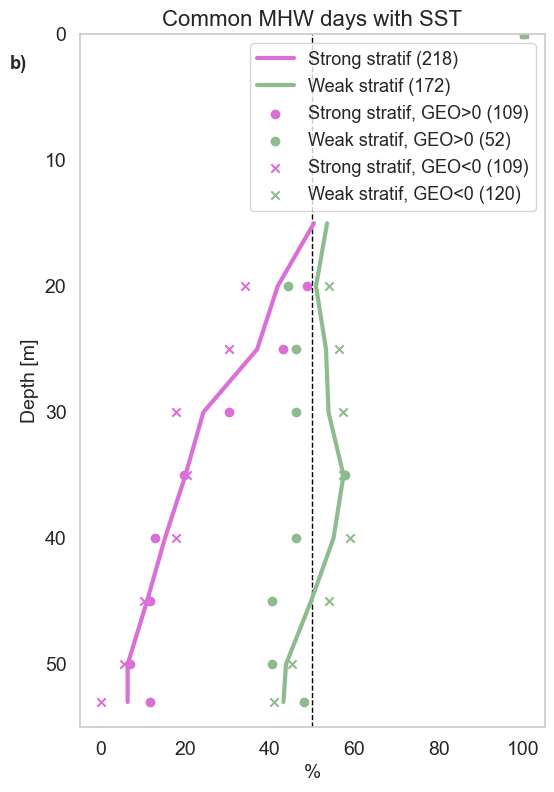

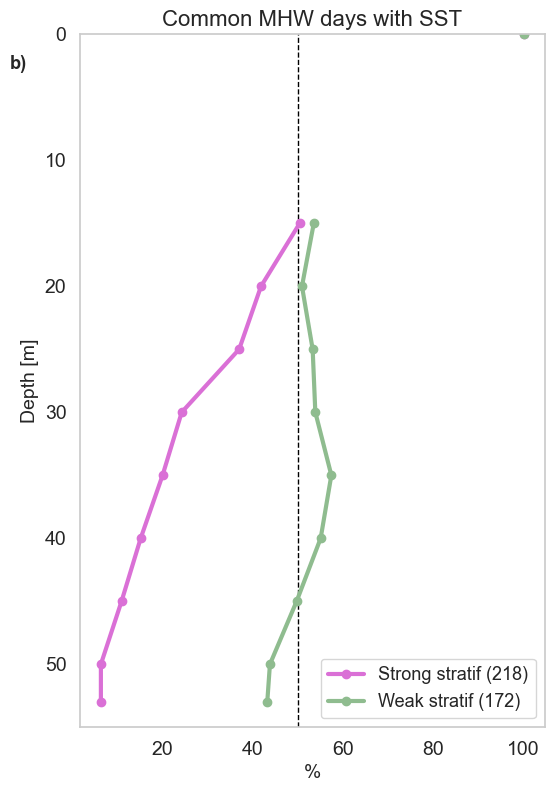

In [9]:
# ARCTICLE figure 5b: coherence

plt.rc('font', size=13)

fig, ax = plt.subplots(figsize=(6, 9))
plt.axvline(50, color='black', linewidth=1, linestyle='dashed')
plt.plot(common_days_summer_perc, Depth_alladd, color='orchid', linewidth=3, label='Strong stratif ({:.0f})'.format(common_days_summer[0]))
plt.plot(common_days_winter_perc, Depth_alladd, color='darkseagreen', linewidth=3, label='Weak stratif ({:.0f})'.format(common_days_winter[0]))
plt.scatter(common_days_summer_GEO_pos_perc, Depth_alladd, color='orchid', label='Strong stratif, GEO>0 ({:.0f})'.format(common_days_summer_GEO_pos[0]))
plt.scatter(common_days_winter_GEO_pos_perc, Depth_alladd, color='darkseagreen', label='Weak stratif, GEO>0 ({:.0f})'.format(common_days_winter_GEO_pos[0]))
plt.scatter(common_days_summer_GEO_neg_perc, Depth_alladd, color='orchid', label='Strong stratif, GEO<0 ({:.0f})'.format(common_days_summer_GEO_neg[0]), marker='x')
plt.scatter(common_days_winter_GEO_neg_perc, Depth_alladd, color='darkseagreen', label='Weak stratif, GEO<0 ({:.0f})'.format(common_days_winter_GEO_neg[0]), marker='x')
plt.gca().invert_yaxis()
plt.title('Common MHW days with SST', size=16)
plt.xlabel('%', size=14)
plt.ylabel('Depth [m]', size=14)
plt.legend(fontsize=13)
plt.grid()
plt.ylim(55, 0)
ax.annotate("b)", xy=(-0.15, 0.95), xycoords="axes fraction", fontweight="bold")
plt.savefig(plot_folder + 'plot_MHWS_scatter_common_days_fromSST3_season_geo.png')
plt.savefig(plot_folder + 'plot_MHWS_scatter_common_days_fromSST3_season_geo.pdf')
plt.show()



# Same figure without geostrophy

# Plotting the results
plt.rc('font', size=13)
fig, ax = plt.subplots(figsize=(6, 9))
plt.axvline(50, color='black', linewidth=1, linestyle='dashed')
plt.plot(common_days_summer_perc, Depth_alladd,'-o', color='orchid', linewidth=3, label='Strong stratif ({:.0f})'.format(common_days_summer[0]))
plt.plot(common_days_winter_perc, Depth_alladd,'-o', color='darkseagreen', linewidth=3, label='Weak stratif ({:.0f})'.format(common_days_winter[0]))
plt.gca().invert_yaxis()
plt.title('Common MHW days with SST', size=16)
plt.xlabel('%', size=14)
plt.ylabel('Depth [m]', size=14)
plt.legend(fontsize=13)
plt.grid()
plt.ylim(55, 0)
ax.annotate("b)", xy=(-0.15, 0.95), xycoords="axes fraction", fontweight="bold")
plt.savefig(plot_folder + 'plot_MHWS_scatter_common_days_fromSST3_season_geo_simple.png')
plt.savefig(plot_folder + 'plot_MHWS_scatter_common_days_fromSST3_season_geo_simple.pdf')
plt.show()



C:\Users\Amandine\AppData\Local\Temp\ipykernel_1528\2598285473.py:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  plt.plot(mean_summer, Depth_alladd,'b-o', label='Strong stratif (JFM)', color='orchid')
C:\Users\Amandine\AppData\Local\Temp\ipykernel_1528\2598285473.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-o" (-> color='b'). The keyword argument will take precedence.
  plt.plot(mean_winter, Depth_alladd,'b-o', label='Weak stratif (JAS)', color='darkseagreen')


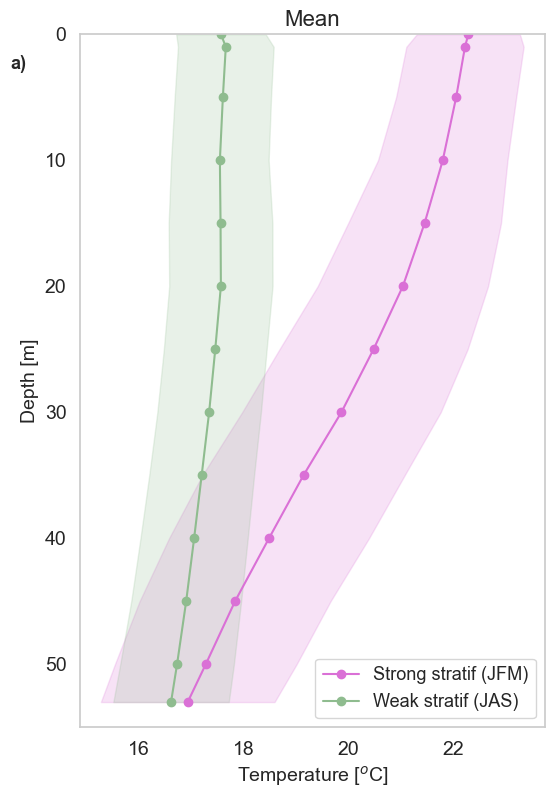

In [10]:
# ARCTICLE figure 5a: mean profile of TEMPERATURE

# Mean and std
mean_summer = np.nanmean(sst_2Dadd[:,summer],axis=1)
std_summer = np.nanstd(sst_2Dadd[:,summer],axis=1)
mean_winter = np.nanmean(sst_2Dadd[:,winter],axis=1)
std_winter = np.nanstd(sst_2Dadd[:,winter],axis=1)

# Figure
fig,ax = plt.subplots(figsize=(6,9))
plt.rc('font', size=13)

plt.plot(mean_summer, Depth_alladd,'b-o', label='Strong stratif (JFM)', color='orchid')
plt.fill_betweenx(Depth_alladd,mean_summer - std_summer, mean_summer + std_summer,alpha=0.2, color='orchid')
plt.plot(mean_winter, Depth_alladd,'b-o', label='Weak stratif (JAS)', color='darkseagreen')
plt.fill_betweenx(Depth_alladd,mean_winter - std_winter, mean_winter + std_winter, alpha=0.2, color='darkseagreen')
plt.gca().invert_yaxis()
plt.title('Mean',size=16)
plt.xlabel('Temperature [$^o$C]',size=14)
plt.ylabel('Depth [m]',size=14)
plt.legend(fontsize = 13)
plt.grid()
ax.annotate("a)", xy=(-0.15, 0.95), xycoords="axes fraction", fontweight="bold")
plt.ylim(55,0)

plt.savefig(plot_folder + 'plot_profiles_temp.png')
plt.savefig(plot_folder + 'plot_profiles_temp.pdf')  
plt.show()

# Define shallow, sub-surface, extended MHWs

In [11]:
# Define different classes of MHWs
np_depths_MHW = (cat_2Dadd > 0).sum(axis=0)

# Extended MHWs: 70% of water column is a MHW day
common_sst_15_70perc = np.where(np_depths_MHW > 7)[0] # More than 7 out of 10 depths are a MHW day
# Grid into a 2d matrix with categories
cat_2Dadd_Barotropic = np.empty((N_FILES+1,len(t_ORS065))) + np.NaN
cat_2Dadd_Barotropic[np.isnan(cat_2Dadd_init)]= 0 # for missing data
cat_2Dadd_Barotropic[:,common_sst_15_70perc] = cat_2Dadd_init[:,common_sst_15_70perc]


# Shallow MHWs: common MHW day at 15m and SST BUT not at 40,45,50,53m
common_sst_15 = np.where((cat_2Dadd[Depth_alladd==0,:]>0) & (cat_2Dadd[Depth_alladd==15,:]>0)  & (cat_2Dadd[Depth_alladd==40,:]==0)
                            & (cat_2Dadd[Depth_alladd==45,:]==0)& (cat_2Dadd[Depth_alladd==50,:]==0) & (cat_2Dadd[Depth_alladd==53,:]==0))[1]
# Grid into a 2d matrix with categories
cat_2Dadd_surf = np.empty((N_FILES+1,len(t_ORS065))) + np.NaN
cat_2Dadd_surf[np.isnan(cat_2Dadd_init)]= 0  #gaps
cat_2Dadd_surf[:,common_sst_15] = cat_2Dadd_init[:,common_sst_15]


# Sub-surface MHWs: common MHW day at 40,45,50,53m BUT not at 15m and SST 
common_53_50_45 = np.where((cat_2Dadd[Depth_alladd==53,:]>0) & (cat_2Dadd[Depth_alladd==50,:]>0) & (cat_2Dadd[Depth_alladd==45,:]>0)
                           & (cat_2Dadd[Depth_alladd==40,:]>0) & (cat_2Dadd[Depth_alladd==15,:]==0) & (cat_2Dadd[Depth_alladd==0,:]==0))[1]
# Grid into a 2d matrix with categories
cat_2Dadd_depth = np.empty((N_FILES+1,len(t_ORS065))) + np.NaN
cat_2Dadd_depth[np.isnan(cat_2Dadd_init)]= 0 #gaps
cat_2Dadd_depth[:,common_53_50_45] = cat_2Dadd_init[:,common_53_50_45] 



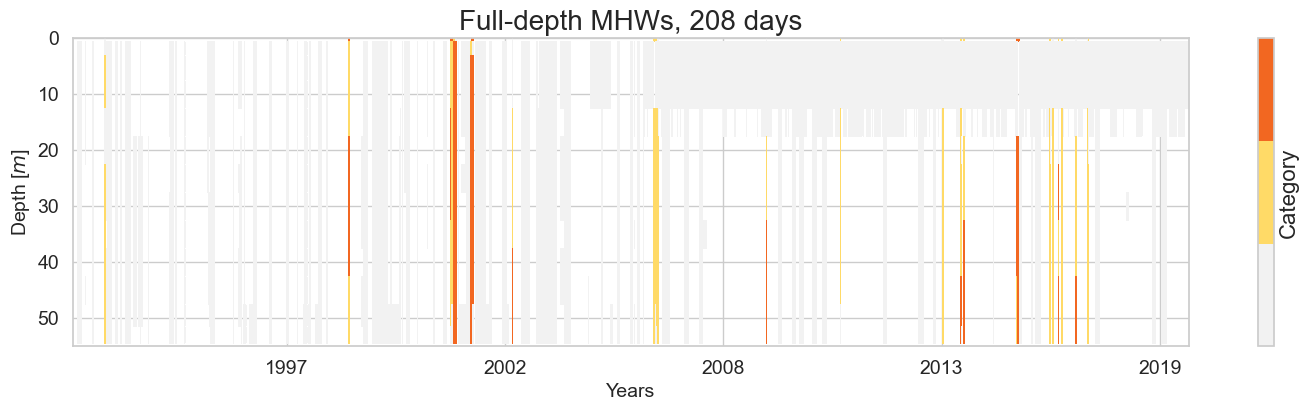

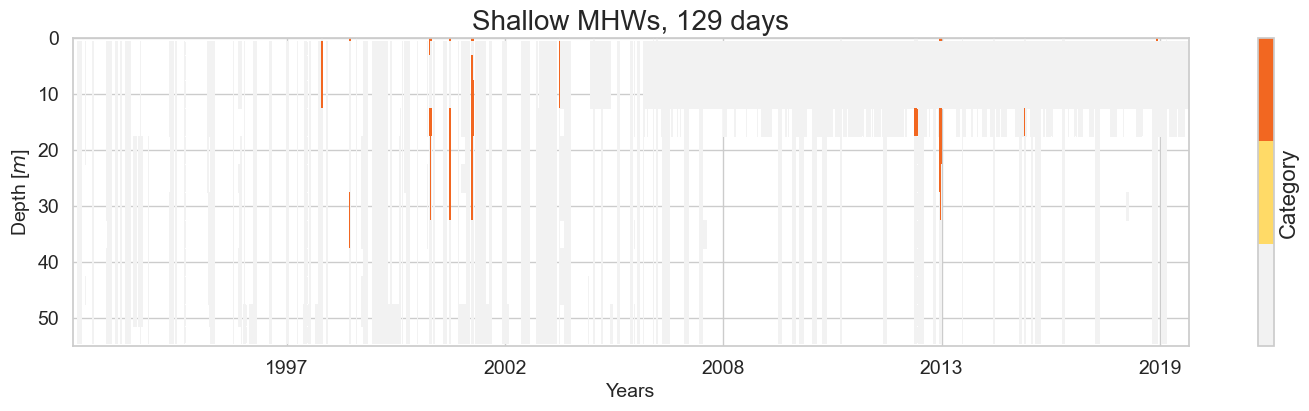

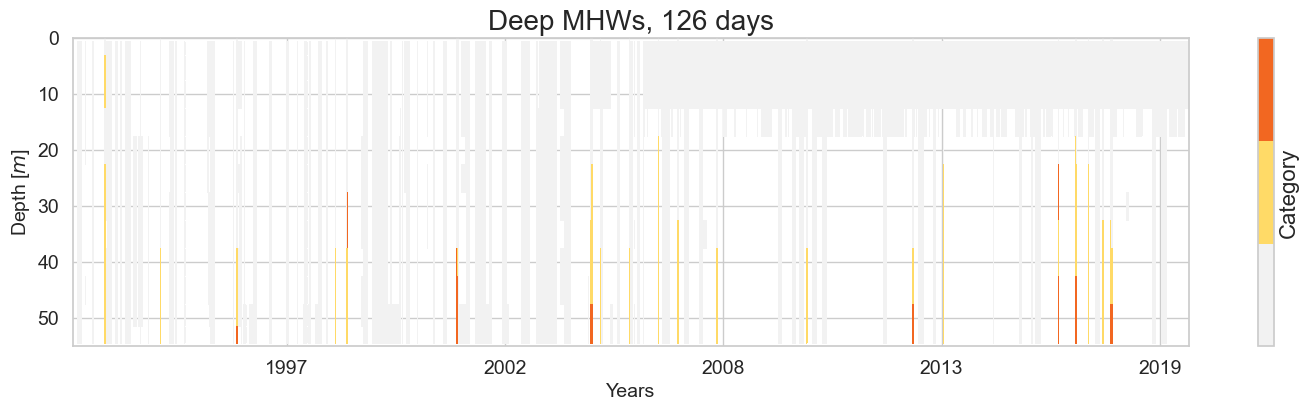

In [12]:
### Figure to visualise categories

cmap_cat = LinearSegmentedColormap.from_list('qqq', colors, N=3)

# Time vector for figure
times_dates0 = np.array([datetime.datetime.fromordinal(t_ORS065[i]) for i in range(1,len(t_ORS065))]) # 0 is the title
t = mdates.date2num(clim_SST['times_dates'])



fig = plt.figure(num=None, figsize=(18, 4) )
plt.rc('font', size=16)

ax = plt.subplot(1,1,1)
plt.pcolor(t,Depth_alladd,cat_2Dadd_Barotropic,cmap=cmap_cat) #PuOr_r
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.clim([0,2])
plt.ylim([55,0])
plt.title('Full-depth MHWs, ' + str(np.size(common_sst_15_70perc)) + ' days', size=20)
cb = plt.colorbar()
plt.xlabel('Years', size=14)
plt.ylabel('Depth [$m$]', size=14)
cb.set_ticks([])
plt.xticks(fontsize= 14) 
plt.yticks(fontsize= 14) 
cb.set_label('Category', size=16)
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
plt.savefig(plot_folder + 'Plot_MHWcategories_baro.png')
plt.show()

fig = plt.figure(num=None, figsize=(18, 4) )
ax = plt.subplot(1,1,1)
plt.pcolor(t,Depth_alladd,cat_2Dadd_surf,cmap=cmap_cat) #PuOr_r
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.clim([0.5,2.5])
plt.ylim([55,0])
plt.title('Shallow MHWs, ' + str(np.size(common_sst_15)) + ' days', size=20)
cb = plt.colorbar()
plt.xlabel('Years', size=14)
plt.ylabel('Depth [$m$]', size=14)
cb.set_ticks([])
plt.xticks(fontsize= 14) 
plt.yticks(fontsize= 14) 
cb.set_label('Category', size=16)
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
plt.savefig(plot_folder + 'Plot_MHWcategories_surf_only.png')
plt.show()

fig = plt.figure(num=None, figsize=(18, 4) )
ax = plt.subplot(1,1,1)
plt.pcolor(t,Depth_alladd,cat_2Dadd_depth,cmap=cmap_cat) #PuOr_r
plt.gca().invert_yaxis()
plt.ylabel('Depth [m]')
plt.clim([-0.5,2.5])
plt.ylim([55,0])
plt.title('Deep MHWs, ' + str(np.size(common_53_50_45)) + ' days', size=20)
cb = plt.colorbar()
plt.xlabel('Years', size=14)
plt.ylabel('Depth [$m$]', size=14)
cb.set_ticks([])
plt.xticks(fontsize= 14) 
plt.yticks(fontsize= 14) 
cb.set_label('Category', size=16)
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
plt.savefig(plot_folder + 'Plot_MHWcategories_depth_only.png')
plt.show()


# Characteristics of shallow, extended, sub-surface events

In [13]:
# RELATING class to characteristics - for each event at 15m, how many days in each class
# If the shallow days are predominant, extract the duration and intensity of the event at 15m.


n_events = mhws_ORS065_15m['n_events']
mhws_ORS065_15m['nb_baro'] = [0]*(n_events)
mhws_ORS065_15m['nb_surf'] = [0]*(n_events)
mhws_ORS065_15m['nb_depth'] = [0]*(n_events)
mhws_ORS065_15m['nb_type'] = [np.nan]*(n_events)

# initialize data of lists.
df = pd.DataFrame()

# loop for events
for i in range(mhws_ORS065_15m['n_events']):          
    t1 = np.where(t_SST==mhws_ORS065_15m['time_start'][i])[0][0]
    t2 = np.where(t_SST==mhws_ORS065_15m['time_end'][i])[0][0]

    # see how many days in this event were a specific MHW type
    event = list(range(t1,t2))
    days_all_types = np.append(np.append(common_sst_15_70perc,common_sst_15,axis=0),common_53_50_45,axis=0)
    if np.intersect1d(event,days_all_types).any():
        mhws_ORS065_15m['nb_baro'][i]= len(np.intersect1d(event,common_sst_15_70perc))
        mhws_ORS065_15m['nb_surf'][i]= len(np.intersect1d(event,common_sst_15))
        mhws_ORS065_15m['nb_depth'][i]= len(np.intersect1d(event,common_53_50_45))
    # FIND which class has the most days
    # NOTE index: 1 if shallow, 2 if extended, 3 if sub-surface
    my_list = (mhws_ORS065_15m['nb_surf'][i],mhws_ORS065_15m['nb_baro'][i],mhws_ORS065_15m['nb_depth'][i])
    index, value = max(enumerate(my_list), key=operator.itemgetter(1))
    dict = {'Days_surf': mhws_ORS065_15m['nb_surf'][i], 'Days_baro': mhws_ORS065_15m['nb_baro'][i], 
            'Days_depth': mhws_ORS065_15m['nb_depth'][i],'Max days': value,'ind': index+1}
    
    df = pd.concat([df, pd.DataFrame([dict])], ignore_index=True)    # in previous python version:  df = df.append(dict, ignore_index = True)    
      
    if np.intersect1d(event,days_all_types).any():
        mhws_ORS065_15m['nb_type'][i] = index+1 # avoid the index 0
        
    
#Get the timing of the events
events_mhws_ORS065_15m_types = np.array(mhws_ORS065_15m['nb_type'])
events_mhws_ORS065_15m_peaks_months = np.array([mhws_ORS065_15m['date_peak'][i].month for i in range(len(mhws_ORS065_15m['date_peak']))]) # 0 is the title
events_mhws_ORS065_15m_peaks_ind = np.array([mhws_ORS065_15m['index_peak'][i] for i in range(len(mhws_ORS065_15m['index_peak']))]) # 0 is the title
events_mhws_ORS065_15m_peaks_ind_SURF = events_mhws_ORS065_15m_peaks_ind[events_mhws_ORS065_15m_types==1]

df # Check

,Days_surf,Days_baro,Days_depth,Max days,ind
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,6,0,0,6,1
5,0,0,0,0,1
6,0,0,0,0,1
7,11,11,0,11,1
8,0,0,0,0,1
9,0,0,0,0,1


In [14]:
# RELATING class to characteristics - for each event at 53m, how many days in each class
# If the sub-surface days are predominant, extract the duration and intensity of the event at 53m.

n_events = mhws_ORS065_53m['n_events']
mhws_ORS065_53m['nb_baro'] = [0] * n_events
mhws_ORS065_53m['nb_surf'] = [0] * n_events
mhws_ORS065_53m['nb_depth'] = [0] * n_events
mhws_ORS065_53m['nb_type'] = [np.nan] * n_events

# Initialize data of lists
df = pd.DataFrame()

# Loop for events
for i in range(n_events):
    t1 = np.where(t_ORS065 == mhws_ORS065_53m['time_start'][i])[0][0]
    t2 = np.where(t_ORS065 == mhws_ORS065_53m['time_end'][i])[0][0]

    # see how many days in this event were a specific MHW type
    event = list(range(t1, t2))
    days_all_types = np.append(np.append(common_sst_15_70perc, common_sst_15, axis=0), common_53_50_45, axis=0)
    if np.intersect1d(event, days_all_types).any():
        mhws_ORS065_53m['nb_baro'][i] = len(np.intersect1d(event, common_sst_15_70perc))
        mhws_ORS065_53m['nb_surf'][i] = len(np.intersect1d(event, common_sst_15))
        mhws_ORS065_53m['nb_depth'][i] = len(np.intersect1d(event, common_53_50_45))

    # FIND which class has the most days
    # NOTE index: 1 if shallow, 2 if extended, 3 if sub-surface
    my_list = (mhws_ORS065_53m['nb_surf'][i], mhws_ORS065_53m['nb_baro'][i], mhws_ORS065_53m['nb_depth'][i])
    index, value = max(enumerate(my_list), key=operator.itemgetter(1))
    dict = {'Days_surf': mhws_ORS065_53m['nb_surf'][i], 'Days_baro': mhws_ORS065_53m['nb_baro'][i],
            'Days_depth': mhws_ORS065_53m['nb_depth'][i], 'Max days': value, 'ind': index + 1}
    df = pd.concat([df, pd.DataFrame([dict])], ignore_index=True)
    if np.intersect1d(event, days_all_types).any():
        mhws_ORS065_53m['nb_type'][i] = index + 1 # avoid the index 0

#Get the timing of the events
events_mhws_ORS065_53m_types = np.array(mhws_ORS065_53m['nb_type'])
events_mhws_ORS065_53m_peaks_months = np.array([mhws_ORS065_53m['date_peak'][i].month for i in range(len(mhws_ORS065_53m['date_peak']))])
events_mhws_ORS065_53m_peaks_ind = np.array([mhws_ORS065_53m['index_peak'][i] for i in range(len(mhws_ORS065_53m['index_peak']))])
events_mhws_ORS065_53m_peaks_ind_DEEP = events_mhws_ORS065_53m_peaks_ind[events_mhws_ORS065_53m_types == 3]

df # Check

,Days_surf,Days_baro,Days_depth,Max days,ind
0,0,0,0,0,1
1,0,5,5,5,2
2,0,0,0,0,1
3,0,0,6,6,3
4,0,0,9,9,3
5,0,0,5,5,3
6,0,0,0,0,1
7,0,0,5,5,3
8,0,6,0,6,2
9,0,0,0,0,1


In [15]:
# RELATING class to characteristics - for each event at 30m, how many days in each class
# If the extended days are predominant, extract the duration and intensity of the event at 30m.


n_events = mhws_ORS065_30m['n_events']
mhws_ORS065_30m['nb_baro'] = [0]*(n_events)
mhws_ORS065_30m['nb_surf'] = [0]*(n_events)
mhws_ORS065_30m['nb_depth'] = [0]*(n_events)
mhws_ORS065_30m['nb_type'] = [np.nan]*(n_events)

# Initialize data of lists
df = pd.DataFrame()

# loop for events
# t_start and t_end
for i in range(mhws_ORS065_30m['n_events']):          
    t1 = np.where(t_ORS065==mhws_ORS065_30m['time_start'][i])[0][0]
    t2 = np.where(t_ORS065==mhws_ORS065_30m['time_end'][i])[0][0]

    # see how many days in this event were a specific MHW type
    event = list(range(t1,t2))
    days_all_types = np.append(np.append(common_sst_15_70perc,common_sst_15,axis=0),common_53_50_45,axis=0)
    if np.intersect1d(event,days_all_types).any():
        mhws_ORS065_30m['nb_baro'][i]= len(np.intersect1d(event,common_sst_15_70perc))
        mhws_ORS065_30m['nb_surf'][i]= len(np.intersect1d(event,common_sst_15))
        mhws_ORS065_30m['nb_depth'][i]= len(np.intersect1d(event,common_53_50_45))
    # FIND which class has the most days
    # NOTE index: 1 if shallow, 2 if extended, 3 if sub-surface
    my_list = (mhws_ORS065_30m['nb_surf'][i],mhws_ORS065_30m['nb_baro'][i],mhws_ORS065_30m['nb_depth'][i])
    index, value = max(enumerate(my_list), key=operator.itemgetter(1))
    dict = {'Days_surf': mhws_ORS065_30m['nb_surf'][i], 'Days_baro': mhws_ORS065_30m['nb_baro'][i], 
            'Days_depth': mhws_ORS065_30m['nb_depth'][i],'Max days': value,'ind': index+1}
    df = pd.concat([df, pd.DataFrame([dict])], ignore_index=True)   
    if np.intersect1d(event,days_all_types).any():
        mhws_ORS065_30m['nb_type'][i] = index+1
        


#Get the timing of the events
events_mhws_ORS065_30m_types = np.array(mhws_ORS065_30m['nb_type'])
events_mhws_ORS065_30m_peaks_months = np.array([mhws_ORS065_30m['date_peak'][i].month for i in range(len(mhws_ORS065_30m['date_peak']))]) # 0 is the title
events_mhws_ORS065_30m_peaks_months
events_mhws_ORS065_30m_peaks_ind = np.array([mhws_ORS065_30m['index_peak'][i] for i in range(len(mhws_ORS065_30m['index_peak']))]) # 0 is the title
events_mhws_ORS065_30m_peaks_ind_BARO = events_mhws_ORS065_30m_peaks_ind[events_mhws_ORS065_30m_types==2]

df # Check

,Days_surf,Days_baro,Days_depth,Max days,ind
0,0,6,6,6,2
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
5,0,0,0,0,1
6,0,0,0,0,1
7,0,10,1,10,2
8,4,0,0,4,1
9,0,0,0,0,1


In [16]:
# Extract the characteristics of events

events_mhws_ORS065_15m_mean_intensity = np.array([mhws_ORS065_15m['intensity_mean'][i] for i in range(len(mhws_ORS065_15m['date_peak']))]) # 0 is the title
events_mhws_ORS065_30m_mean_intensity = np.array([mhws_ORS065_30m['intensity_mean'][i] for i in range(len(mhws_ORS065_30m['date_peak']))]) # 0 is the title
events_mhws_ORS065_53m_mean_intensity = np.array([mhws_ORS065_53m['intensity_mean'][i] for i in range(len(mhws_ORS065_53m['date_peak']))]) # 0 is the title
events_mhws_ORS065_15m_mean_dur = np.array([mhws_ORS065_15m['duration'][i] for i in range(len(mhws_ORS065_15m['date_peak']))]) # 0 is the title
events_mhws_ORS065_30m_mean_dur = np.array([mhws_ORS065_30m['duration'][i] for i in range(len(mhws_ORS065_30m['date_peak']))]) # 0 is the title
events_mhws_ORS065_53m_mean_dur = np.array([mhws_ORS065_53m['duration'][i] for i in range(len(mhws_ORS065_53m['date_peak']))]) # 0 is the title
events_mhws_ORS065_15m_mean_cat = np.array([mhws_ORS065_15m['category'][i] for i in range(len(mhws_ORS065_15m['date_peak']))]) # 0 is the title
events_mhws_ORS065_30m_mean_cat = np.array([mhws_ORS065_30m['category'][i] for i in range(len(mhws_ORS065_30m['date_peak']))]) # 0 is the title
events_mhws_ORS065_53m_mean_cat = np.array([mhws_ORS065_53m['category'][i] for i in range(len(mhws_ORS065_53m['date_peak']))]) # 0 is the title

events_mhws_ORS065_15m_start_t = np.array([mhws_ORS065_15m['time_start'][i] for i in range(len(mhws_ORS065_15m['date_peak']))]) # 0 is the title
events_mhws_ORS065_15m_end_t = np.array([mhws_ORS065_15m['time_end'][i] for i in range(len(mhws_ORS065_15m['date_peak']))]) # 0 is the title
events_mhws_ORS065_30m_start_t = np.array([mhws_ORS065_30m['time_start'][i] for i in range(len(mhws_ORS065_30m['date_peak']))]) # 0 is the title
events_mhws_ORS065_30m_end_t = np.array([mhws_ORS065_30m['time_end'][i] for i in range(len(mhws_ORS065_30m['date_peak']))]) # 0 is the title
events_mhws_ORS065_53m_start_t = np.array([mhws_ORS065_53m['time_start'][i] for i in range(len(mhws_ORS065_53m['date_peak']))]) # 0 is the title
events_mhws_ORS065_53m_end_t = np.array([mhws_ORS065_53m['time_end'][i] for i in range(len(mhws_ORS065_53m['date_peak']))]) # 0 is the title


df_surf = pd.DataFrame({'Month': events_mhws_ORS065_15m_peaks_months[events_mhws_ORS065_15m_types==1],
                    'Intensity': events_mhws_ORS065_15m_mean_intensity[events_mhws_ORS065_15m_types==1],
                    'Duration': events_mhws_ORS065_15m_mean_dur[events_mhws_ORS065_15m_types==1],
                    'category': events_mhws_ORS065_15m_mean_cat[events_mhws_ORS065_15m_types==1],
                    'time_start':events_mhws_ORS065_15m_start_t[events_mhws_ORS065_15m_types==1],
                    'time_end':events_mhws_ORS065_15m_end_t[events_mhws_ORS065_15m_types==1],
                    'label':"Shallow MHW"})
df_baro = pd.DataFrame({'Month': events_mhws_ORS065_30m_peaks_months[events_mhws_ORS065_30m_types==2],
                        'Intensity': events_mhws_ORS065_30m_mean_intensity[events_mhws_ORS065_30m_types==2],
                        'Duration': events_mhws_ORS065_30m_mean_dur[events_mhws_ORS065_30m_types==2],
                        'category': events_mhws_ORS065_30m_mean_cat[events_mhws_ORS065_30m_types==2],
                        'time_start':events_mhws_ORS065_30m_start_t[events_mhws_ORS065_30m_types==2],
                        'time_end':events_mhws_ORS065_30m_end_t[events_mhws_ORS065_30m_types==2],
                        'label':"Full-depth MHW"})
df_depth = pd.DataFrame({'Month': events_mhws_ORS065_53m_peaks_months[events_mhws_ORS065_53m_types==3],
                         'Intensity': events_mhws_ORS065_53m_mean_intensity[events_mhws_ORS065_53m_types==3],
                         'Duration': events_mhws_ORS065_53m_mean_dur[events_mhws_ORS065_53m_types==3],
                         'category': events_mhws_ORS065_53m_mean_cat[events_mhws_ORS065_53m_types==3],
                         'time_start':events_mhws_ORS065_53m_start_t[events_mhws_ORS065_53m_types==3],
                         'time_end':events_mhws_ORS065_53m_end_t[events_mhws_ORS065_53m_types==3],
                         'label':"Deep MHW"})


# Count events per month
events_by_monthf_surf = df_surf.groupby(df_surf.Month).count()
events_by_monthf_baro = df_baro.groupby(df_baro.Month).count()
events_by_mont_depth = df_depth.groupby(df_depth.Month).count()


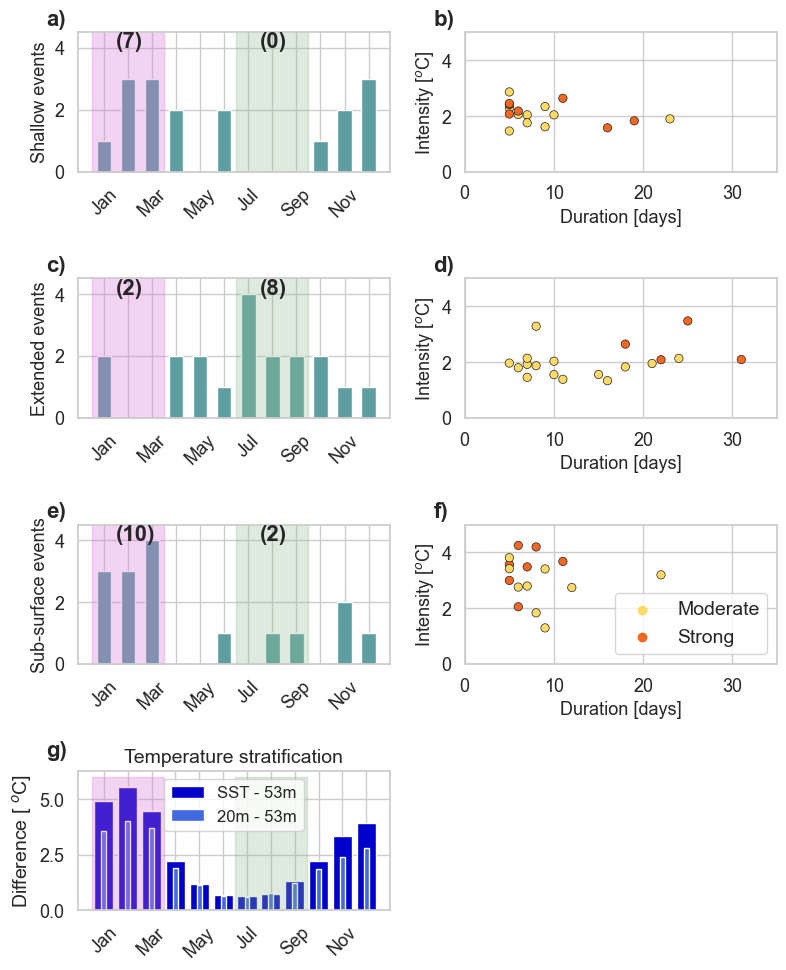

In [17]:
# ARCTICLE figure 3

# pallete categories
col_cat0 = (.95, .95, .95) # no
col_cat1 =  (255/255, 218/255, 103/255) # Moderate
col_cat2 =  (242/255, 103/255, 33/255) # Strong
colors = [col_cat1, col_cat2]
customPalette_cat = sns.set_palette(sns.color_palette(colors))


# Same figure but better;)
bar_width = 0.6
monthNames = ['Jan', ' ', 'Mar', ' ', 'May', ' ', 'Jul', ' ', 'Sep', ' ', 'Nov', ' ']
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13) 

fig = plt.figure(figsize=(8,10))
ax = plt.subplot(4,2,1)
plt.bar(events_by_monthf_surf.index,events_by_monthf_surf.Intensity,bar_width, color="cadetblue")#,label='EAC jet core, surface')
ax.set_xticks(np.arange(12)+1)
ax.set_xticklabels(monthNames,fontsize=13, rotation = 45)
ax.set(ylabel='Shallow events')
ax.xaxis.get_label().set_fontsize(13), 
ax.yaxis.get_label().set_fontsize(13)
ax.set(ylim=(0, 4.5))
ax.annotate("a)", xy=(-0.1, 1.05), xycoords="axes fraction", fontweight="bold")
ax.fill_between([0.5,3.5],0,6, color='orchid', alpha=0.3)
ax.fill_between([6.5,9.5],0,6, color='darkseagreen', alpha=0.3)
ax.annotate('(' + str(events_by_monthf_surf.loc[1:3].Intensity.sum()) + ')', xy=(1.5, 4), fontweight="bold") # sum summer events
ax.annotate('(' + str(events_by_monthf_surf.loc[7:9].Intensity.sum()) + ')', xy=(7.5, 4), fontweight="bold") # sum winter events


ax = plt.subplot(4,2,3)
plt.bar(events_by_monthf_baro.index,events_by_monthf_baro.Intensity,bar_width, color="cadetblue",)#,label='EAC jet core, surface')
ax.set_xticks(np.arange(12)+1)
ax.set_xticklabels(monthNames,fontsize=13, rotation = 45)
ax.set(ylabel='Extended events')
ax.xaxis.get_label().set_fontsize(13), 
ax.yaxis.get_label().set_fontsize(13)
ax.set(ylim=(0, 4.5))
ax.annotate("c)", xy=(-0.1, 1.05), xycoords="axes fraction", fontweight="bold")
ax.fill_between([0.5,3.5],0,6, color='orchid', alpha=0.3)
ax.fill_between([6.5,9.5],0,6, color='darkseagreen', alpha=0.3)
ax.annotate('(' + str(events_by_monthf_baro.loc[1:3].Intensity.sum()) + ')', xy=(1.5, 4), fontweight="bold") # sum summer events
ax.annotate('(' + str(events_by_monthf_baro.loc[7:9].Intensity.sum()) + ')', xy=(7.5, 4), fontweight="bold") # sum winter events

ax = plt.subplot(4,2,5)
plt.bar(events_by_mont_depth.index,events_by_mont_depth.Intensity,bar_width, color="cadetblue")#,label='EAC jet core, surface')
ax.set_xticks(np.arange(12)+1)
ax.set_xticklabels(monthNames,fontsize=13, rotation = 45)
ax.set(ylabel='Sub-surface events')
ax.xaxis.get_label().set_fontsize(13), 
ax.yaxis.get_label().set_fontsize(13)
ax.set(ylim=(0, 4.5))
ax.annotate("e)", xy=(-0.1, 1.05), xycoords="axes fraction", fontweight="bold")
ax.fill_between([0.5,3.5],0,6, color='orchid', alpha=0.3)
ax.fill_between([6.5,9.5],0,6, color='darkseagreen', alpha=0.3)
ax.annotate('(' + str(events_by_mont_depth.loc[1:3].Intensity.sum()) + ')', xy=(1.5, 4), fontweight="bold") # sum summer events
ax.annotate('(' + str(events_by_mont_depth.loc[7:9].Intensity.sum()) + ')', xy=(7.5, 4), fontweight="bold") # sum winter events

ax = plt.subplot(4,2,2)
ax = sns.scatterplot(data=df_surf, x="Duration" , y="Intensity", hue='category', legend='',edgecolor="k", palette = customPalette_cat)
ax.set(xlim=(0, 35)), ax.set(ylim=(0, 5))
ax.set(ylabel='Intensity [$^o$C]')
ax.set(xlabel='Duration [days]')
plt.xticks(fontsize= 13) , plt.yticks(fontsize= 13) 
ax.xaxis.get_label().set_fontsize(13), ax.yaxis.get_label().set_fontsize(13)
ax.annotate("b)", xy=(-0.1, 1.05), xycoords="axes fraction", fontweight="bold")

ax = plt.subplot(4,2,4)
ax = sns.scatterplot(data=df_baro, x="Duration" , y="Intensity", hue='category', legend='',edgecolor="k")
ax.set(xlim=(0, 35)), ax.set(ylim=(0, 5))
ax.set(ylabel='Intensity [$^o$C]')
ax.set(xlabel='Duration [days]')
plt.xticks(fontsize= 13) , plt.yticks(fontsize= 13) 
ax.xaxis.get_label().set_fontsize(13), ax.yaxis.get_label().set_fontsize(13)
ax.annotate("d)", xy=(-0.1, 1.05), xycoords="axes fraction", fontweight="bold")


ax = plt.subplot(4,2,6)
ax = sns.scatterplot(data=df_depth, x="Duration" , y="Intensity", hue='category',edgecolor="k")
ax.set(xlim=(0, 35)), ax.set(ylim=(0, 5))
ax.set(ylabel='Intensity [$^o$C]')
ax.set(xlabel='Duration [days]')
plt.xticks(fontsize= 13) , plt.yticks(fontsize= 13) 
ax.xaxis.get_label().set_fontsize(13), ax.yaxis.get_label().set_fontsize(13)
plt.legend( loc=4, ncol=1, fontsize = 14)
ax.annotate("f)", xy=(-0.1, 1.05), xycoords="axes fraction", fontweight="bold")

ax = plt.subplot(4,2,7)
plt.title(Name_platform, size=15)
plt.bar(stratif_by_month.index,stratif_by_month.temp_diff_SST_50m,0.8,label='SST - 53m',color='mediumblue')
plt.bar(stratif_by_month.index,stratif_by_month.temp_diff_20m_50m,0.2,label='20m - 53m',color='royalblue')
ax.set_xticks(np.arange(12)+1)
plt.legend(fontsize=12,loc=9)    
ax.set_xticklabels(monthNames,fontsize=13, rotation = 45)
ax.set_title('Temperature stratification',fontsize=14)    
ax.set_ylabel('Difference [ $^{o}$C]',fontsize=14)    
ax.annotate("g)", xy=(-0.1, 1.1), xycoords="axes fraction", fontweight="bold")
ax.fill_between([0.5,3.5],0,6, color='orchid', alpha=0.3)
ax.fill_between([6.5,9.5],0,6, color='darkseagreen', alpha=0.3)


fig.tight_layout()
plt.savefig(plot_folder + 'Plot_depthtypes_month_int_dur_v2_wirthStratif.png')
plt.savefig(plot_folder + 'Plot_depthtypes_month_int_dur_v2_wirthStratif.pdf')  
plt.show()





# Distribution events by season

In [18]:
# Hypothesis testing:

# SURFACE
nb_surf_events_tot  = events_by_monthf_surf.Intensity.sum()
nb_surf_events_summer  = events_by_monthf_surf.loc[1:3].Intensity.sum()
# is there evidence that there are more surf events in summer than any other season?
proportions_ztest(count=nb_surf_events_summer, nobs=nb_surf_events_tot, value=1/4,alternative='larger')
#(1.3552147958375982, 0.08767456600256307)

# DEEP
nb_depth_events_tot  = events_by_mont_depth.Intensity.sum()
nb_depth_events_summer  = events_by_mont_depth.loc[1:3].Intensity.sum()
# is there evidence that there are more deep events in summer than any other season?
proportions_ztest(count=nb_depth_events_summer, nobs=nb_depth_events_tot, value=1/4,alternative='larger')
#(3.0983866769659336, 0.0009728868468695743)

# Extended / baro
nb_baro_events_tot  = events_by_monthf_baro.Intensity.sum()
nb_baro_events_winter  = events_by_monthf_baro.loc[7:9].Intensity.sum()
# is there evidence that there are more deep events in winter than any other season?
proportions_ztest(count=nb_baro_events_winter, nobs=nb_baro_events_tot, value=1/4,alternative='larger')
#(1.5101456130874507, 0.06550313638389177)




(1.5101456130874507, 0.06550313638389177)

# Save timing of surface, extended and sub-surface events

In [19]:
### Get all times in each types of events

dates_df_depth_start = [date.fromordinal(df_depth['time_start'][i]) for i in range(len(df_depth['time_start'])) ]
dates_df_depth_end = [date.fromordinal(df_depth['time_end'][i]) for i in range(len(df_depth['time_end'])) ]
dates_df_depth_all = []
for i in range(len(dates_df_depth_start)):
    dates_df_depth_all = np.append(dates_df_depth_all,np.arange(dates_df_depth_start[i], dates_df_depth_end[i], timedelta(days=1)).astype(datetime.datetime), axis=0)

    
dates_df_surf_start = [date.fromordinal(df_surf['time_start'][i]) for i in range(len(df_surf['time_start'])) ]
dates_df_surf_end = [date.fromordinal(df_surf['time_end'][i]) for i in range(len(df_surf['time_end'])) ]
dates_df_surf_all = []
for i in range(len(dates_df_surf_start)):
    dates_df_surf_all = np.append(dates_df_surf_all,np.arange(dates_df_surf_start[i], dates_df_surf_end[i], timedelta(days=1)).astype(datetime.datetime), axis=0)
    
dates_df_baro_start = [date.fromordinal(df_baro['time_start'][i]) for i in range(len(df_baro['time_start'])) ]
dates_df_baro_end = [date.fromordinal(df_baro['time_end'][i]) for i in range(len(df_baro['time_end'])) ]
dates_df_baro_all = []
for i in range(len(dates_df_baro_start)):
    dates_df_baro_all = np.append(dates_df_baro_all,np.arange(dates_df_baro_start[i], dates_df_baro_end[i], timedelta(days=1)).astype(datetime.datetime), axis=0)
    


In [20]:
# SAVE
## Save the data in file
import shelve
d = shelve.open('DATA_processed/SSAVE_' + Name_platform + 'times_MHWtypes_daily_2020_sst2019')
d['common_times_baro'] = common_sst_15_70perc          
d['common_times_depth'] = common_53_50_45            
d['common_times_surf'] = common_sst_15            
d['events_mhws_ORS065_15m_peaks_ind_SURF'] = events_mhws_ORS065_15m_peaks_ind_SURF           
d['events_mhws_ORS065_30m_peaks_ind_BARO'] = events_mhws_ORS065_30m_peaks_ind_BARO            
d['events_mhws_ORS065_53m_peaks_ind_DEEP'] = events_mhws_ORS065_53m_peaks_ind_DEEP        
d.close()  


# PLOT  temperature anomalies for all decades with MLD

In [21]:
## Compute MLD

sst_2Dadd0 = np.vstack([sst_2Dadd[0,:]]*len(Depth_alladd)) # OR np.tile(sst_2Dadd[0,:],(len(Depth_alladd),1))
sst_2Dadd_diff  = sst_2Dadd0 - sst_2Dadd

parameter_mld = 0.5
index_mld = len(Depth_alladd) - np.sum(sst_2Dadd_diff > parameter_mld,axis=0)-1 # because indexing starts at 0
# Careful, since there are a few NaNs need to start from the bottom
mld = Depth_alladd[index_mld]
# Check days with too many NaNs
nb_nans = len(Depth_alladd) - np.sum(sst_2Dadd_diff > -999,axis=0)
mld[nb_nans>len(Depth_alladd)-2] = np.NaN

# Moving average
N = 5
mld_smooth5 = np.convolve(mld, np.ones((N,))/N, mode='same') 



In [22]:
# Instruments depth:
instr_depths_beg = [0.6, 6.5, 10.5, 14.5, 17, 22.7, 26.1, 29.5, 32.9, 36.3, 39.7, 43.1, 46.5, 49.9,53]
instr_depths_IMOS = [16,20,24,28,32,36,40,44,48,52,56,60,64]

# Grid for plotting
dates_df_depth_start = [date.fromordinal(df_depth['time_start'][i]) for i in range(len(df_depth['time_start'])) ]
dates_df_depth_end = [date.fromordinal(df_depth['time_end'][i]) for i in range(len(df_depth['time_end'])) ]
dates_df_depth_all = []
for i in range(len(dates_df_depth_start)):
    dates_df_depth_all = np.append(dates_df_depth_all,np.arange(dates_df_depth_start[i], dates_df_depth_end[i], timedelta(days=1)).astype(datetime.datetime), axis=0)



C:\Users\Amandine\AppData\Local\Temp\ipykernel_1528\1162702341.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap('PuOr_r')


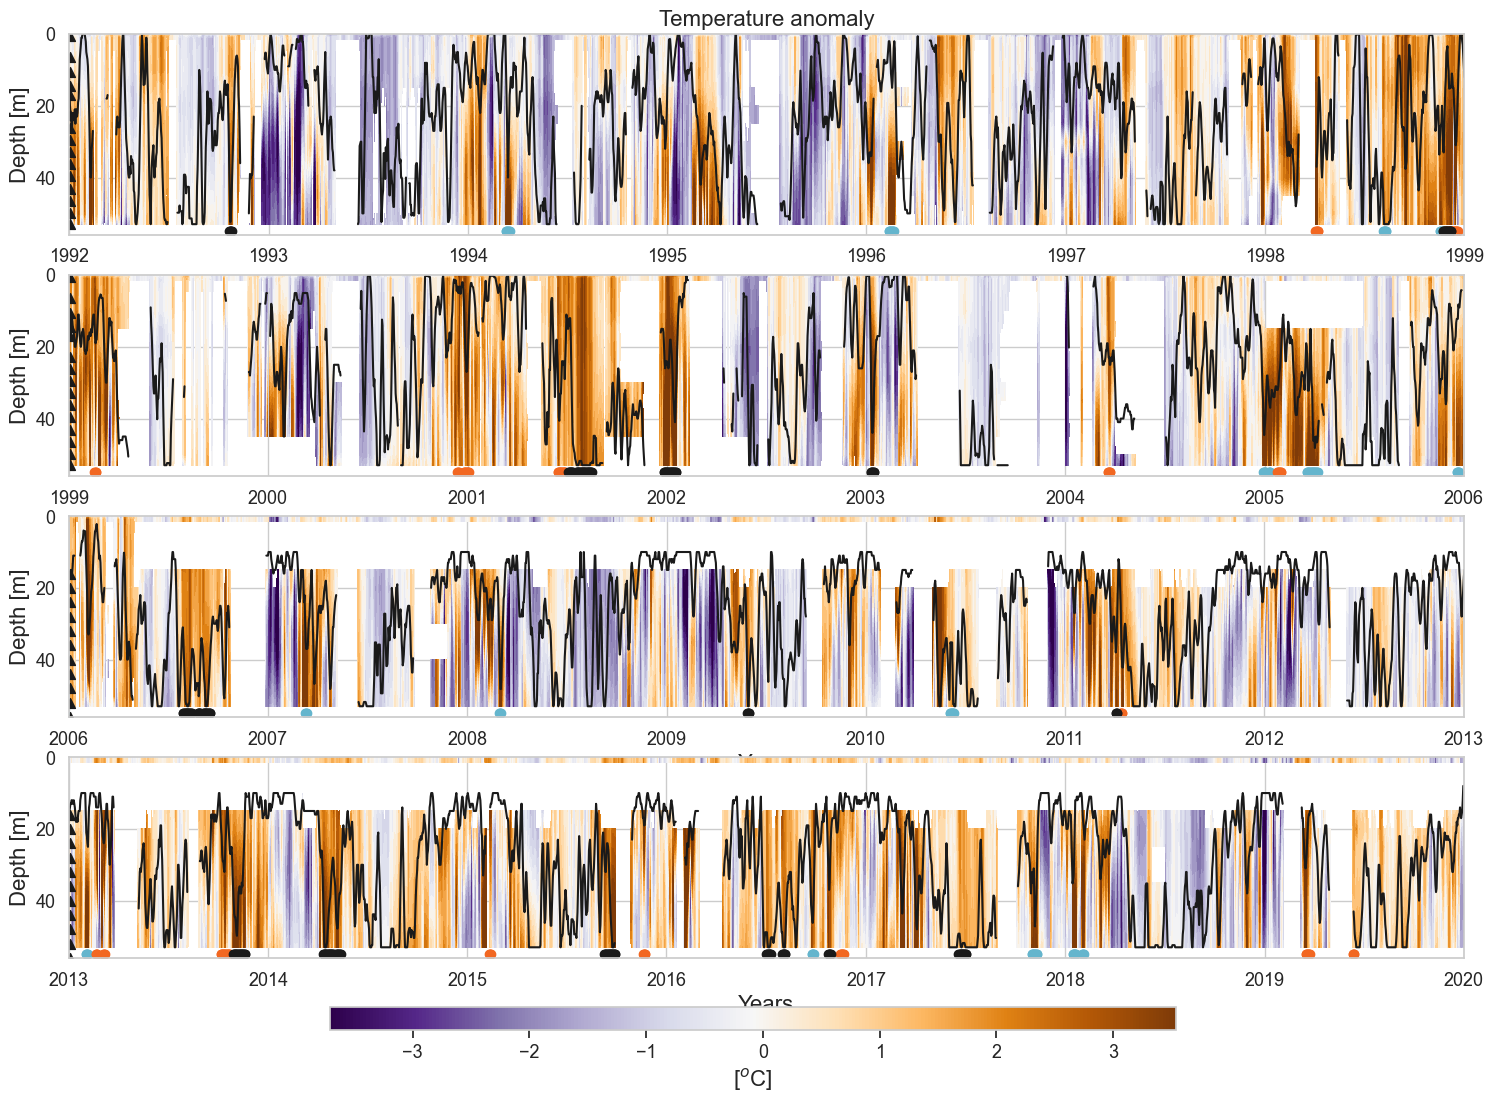

In [23]:
# ARTICLE figure 2

t = mdates.date2num(clim_SST['times_dates'])

jet = plt.cm.get_cmap('PuOr_r')

fig = plt.figure(num=None, figsize=(18, 12) )
ax = plt.subplot(4,1,1)
plt.pcolor(t,np.array([0,3]),sst_ano_2Dadd[0:2,:],cmap=jet) #PuOr_r  Add SST over 0-3m to see SST
plt.contourf(t,Depth_alladd,sst_ano_2Dadd,cmap=jet,levels =  np.linspace(-3, 3, 33),extend='both') 
plt.plot(t,mld_smooth5,'k-')
plt.plot(dates_df_depth_all,np.zeros(len(dates_df_depth_all))+55,'co')
plt.plot(dates_df_surf_all,np.zeros(len(dates_df_surf_all))+55,'C1o')
plt.plot(dates_df_baro_all,np.zeros(len(dates_df_baro_all))+55,'ko')
plt.gca().invert_yaxis()
#
plt.ylim([56,0])
plt.title('Temperature anomaly', size=16)
plt.ylabel('Depth [m]', size=16)
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlim([datetime.date(1992, 1, 1), datetime.date(1999, 1, 1)])

date = datetime.datetime(2001,7,27); ylim0 = (18, 21) #  Full depth
date = datetime.datetime(2000,12,29); ylim0 = (15, 25) # Shallow
plt.scatter([datetime.date(1992, 1, 3) for each in range(len(instr_depths_beg))], instr_depths_beg,color='k',s=50,marker='^')

ax = plt.subplot(4,1,2)
plt.pcolor(t,np.array([0,3]),sst_ano_2Dadd[0:2],cmap=jet) #PuOr_r  Add SST over 0-3m to make it bigger
# plt.clim([-3,3])
plt.contourf(t,Depth_alladd,sst_ano_2Dadd,cmap=jet,levels =  np.linspace(-3, 3, 33),extend='both') #PuOr_r # RdBu_r
plt.plot(t,mld_smooth5,'k-')
plt.plot(dates_df_depth_all,np.zeros(len(dates_df_depth_all))+55,'co')
plt.plot(dates_df_surf_all,np.zeros(len(dates_df_surf_all))+55,'C1o')
plt.plot(dates_df_baro_all,np.zeros(len(dates_df_baro_all))+55,'ko')
plt.gca().invert_yaxis()
plt.ylim([56,0])
plt.ylabel('Depth [m]', size=16)
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlim([datetime.date(1999, 1, 1), datetime.date(2006, 1, 1)])
plt.scatter([datetime.date(1999, 1, 3) for each in range(len(instr_depths_beg))], instr_depths_beg,color='k',s=50,marker='^')

ax = plt.subplot(4,1,3)
plt.pcolor(t,np.array([0,3]),sst_ano_2Dadd[0:2,:],cmap=jet) #PuOr_r # Add SST over 0-3m to make it bigger
plt.contourf(t,Depth_alladd,sst_ano_2Dadd,cmap=jet,levels =  np.linspace(-3, 3, 33),extend='both') #PuOr_r # RdBu_r
plt.plot(t,mld_smooth5,'k-')
plt.plot(dates_df_depth_all,np.zeros(len(dates_df_depth_all))+55,'co')
plt.plot(dates_df_surf_all,np.zeros(len(dates_df_surf_all))+55,'C1o')
plt.plot(dates_df_baro_all,np.zeros(len(dates_df_baro_all))+55,'ko')
plt.gca().invert_yaxis()
plt.xlim([1994,2004])
plt.ylim([56,0])

plt.xlabel('Years', size=16)
plt.ylabel('Depth [m]', size=16)
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlim([datetime.date(2006, 1, 1), datetime.date(2013, 1, 1)])
plt.scatter([datetime.date(2006, 1, 3) for each in range(len(instr_depths_IMOS))], instr_depths_IMOS,color='k',s=50,marker='^')

ax = plt.subplot(4,1,4)
ax_plot = plt.pcolor(t,np.array([0,3]),sst_ano_2Dadd[0:2,:],cmap=jet) #PuOr_r # Add SST over 0-3m to make it bigger
plt.contourf(t,Depth_alladd,sst_ano_2Dadd,cmap=jet,levels =  np.linspace(-3, 3, 33),extend='both') #PuOr_r # RdBu_r
plt.plot(t,mld_smooth5,'k-')
plt.plot(dates_df_depth_all,np.zeros(len(dates_df_depth_all))+55,'co')
plt.plot(dates_df_surf_all,np.zeros(len(dates_df_surf_all))+55,'C1o')
plt.plot(dates_df_baro_all,np.zeros(len(dates_df_baro_all))+55,'ko')
plt.gca().invert_yaxis()
plt.xlim([1994,2004])
plt.ylim([56,0])

plt.xlabel('Years', size=16)
plt.ylabel('Depth [m]', size=16)
date_format = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlim([datetime.date(2013, 1, 1), datetime.date(2020, 1, 1)])
plt.scatter([datetime.date(2013, 1, 3) for each in range(len(instr_depths_IMOS))], instr_depths_IMOS,color='k',s=50,marker='^')


date = datetime.datetime(2018,1,17); 

# Colorbar below
cbaxes = fig.add_axes([0.27, 0.05, 0.47, 0.019])
cb = plt.colorbar(ax_plot, orientation='horizontal',cax=cbaxes,aspect = 0.5,shrink=0.8)
cb.set_label('[$^o$C]', size=16)



# fig.tight_layout()

plt.savefig(plot_folder + 'Plot_tempA_ORSdepth_all_subplots_decades_MLD05_smooth5_4panels.png')
plt.savefig(plot_folder + 'Plot_tempA_ORSdepth_all_subplots_decades_MLD05_smooth5_4panels.pdf')  
plt.show()



# Comparison SST and surface in situ  temperature until 2006

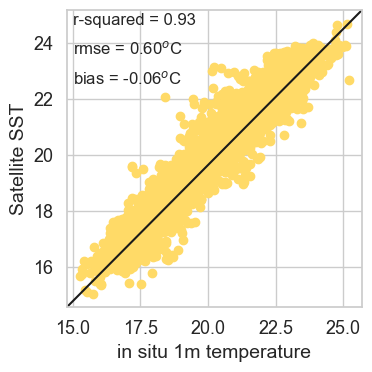

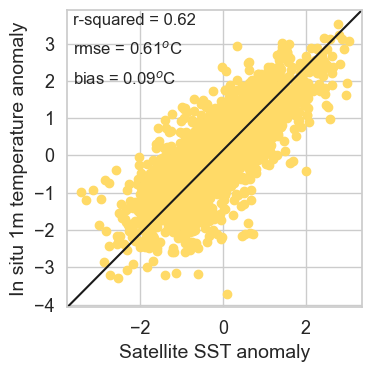

In [24]:
#### ARCTICLE figure S1

fig,ax = plt.subplots(figsize=(4,4))
y = sst_2Dadd[0,:]
x = sst_2Dadd[1,:]
plt.scatter(x,y)
plt.ylabel('Satellite SST', fontsize=14)
plt.xlabel('in situ 1m temperature', fontsize=14)

# Trend: linear regression
nogaps = (~np.isnan(x) & ~np.isnan(y))    
slope, intercept, r_value, p_value, std_err = stats.linregress(x[nogaps],y[nogaps]) 
mse = np.square(np.subtract(x[nogaps],y[nogaps])).mean()
rmse = np.sqrt(mse)
bias = (y[nogaps]-x[nogaps]).mean()

ax.annotate("r-squared = {:.2f}".format(r_value**2), (0.02, 0.95), fontsize=12,xycoords="axes fraction")
ax.annotate("rmse = {:.2f}".format(rmse) + '$^o$C', (0.02, 0.85), fontsize=12,xycoords="axes fraction")
ax.annotate("bias = {:.2f}".format(bias) + '$^o$C', (0.02, 0.75), fontsize=12,xycoords="axes fraction")
plt.plot([0,1],[0,1],'k', transform=ax.transAxes)

plt.tight_layout()
plt.savefig(plot_folder + 'plot_scatter_SST_temp1m.png', bbox_inches='tight', pad_inches=0.5, dpi=150)
plt.savefig(plot_folder + 'plot_scatter_SST_temp1m.pdf')  
plt.show()

### ANO

fig,ax = plt.subplots(figsize=(4,4))
x = sst_ano_2Dadd[0,:]
y = sst_ano_2Dadd[1,:]
plt.scatter(x,y)
plt.xlabel('Satellite SST anomaly', fontsize=14)
plt.ylabel('In situ 1m temperature anomaly', fontsize=14)
plt.plot([0,1],[0,1],'k', transform=ax.transAxes)

from scipy import stats
# Trend: linear regression
nogaps = (~np.isnan(x) & ~np.isnan(y))    
slope, intercept, r_value, p_value, std_err = stats.linregress(x[nogaps],y[nogaps]) 
mse = np.square(np.subtract(x[nogaps],y[nogaps])).mean()
rmse = np.sqrt(mse)
bias = (y[nogaps]-x[nogaps]).mean()

ax.annotate("r-squared = {:.2f}".format(r_value**2), (0.02, 0.95), fontsize=12,xycoords="axes fraction")
ax.annotate("rmse = {:.2f}".format(rmse) + '$^o$C', (0.02, 0.85), fontsize=12,xycoords="axes fraction")
ax.annotate("bias = {:.2f}".format(bias) + '$^o$C', (0.02, 0.75), fontsize=12,xycoords="axes fraction")
# ax.set_title('R2: ' + str(r2_score(y_test, y_predicted)))

plt.tight_layout()
plt.savefig(plot_folder + 'plot_scatter_SST_temp1m_ano.png', bbox_inches='tight', pad_inches=0.5, dpi=150)
plt.savefig(plot_folder + 'plot_scatter_SST_temp1m_ano.pdf')  
plt.show()
